In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl 

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [7]:
def get_historical_data(symbol, start_date = None):
    api_key = open(r'api_key.txt')
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

ibm = get_historical_data('IBM', '2005-01-01')
ibm

,open,high,low,close,adj close,volume
2005-01-03,98.97,99.10,97.2500,97.75,54.999391,5295200.0
2005-01-04,97.74,98.42,96.5200,96.70,54.408604,5711000.0
2005-01-05,96.60,97.83,96.4000,96.50,54.296074,5646700.0
2005-01-06,96.54,96.98,96.0500,96.20,54.127278,4561700.0
2005-01-07,96.50,96.80,95.4700,95.78,53.890963,6200700.0
...,...,...,...,...,...,...
2023-05-01,126.35,126.75,126.0600,126.09,126.090000,2724992.0
2023-05-02,126.30,126.45,123.2700,125.16,125.160000,4445283.0
2023-05-03,125.46,125.57,123.2600,123.45,123.450000,4554212.0
2023-05-04,123.03,123.52,121.7563,122.57,122.570000,4468237.0


In [8]:
ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4617 entries, 2005-01-03 to 2023-05-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4617 non-null   float64
 1   high       4617 non-null   float64
 2   low        4617 non-null   float64
 3   close      4617 non-null   float64
 4   adj close  4617 non-null   float64
 5   volume     4617 non-null   float64
dtypes: float64(6)
memory usage: 252.5 KB


In [9]:
ibm.describe()

,open,high,low,close,adj close,volume
count,4617.000000,4617.000000,4617.000000,4617.000000,4617.000000,4.617000e+03
mean,138.909840,140.056955,137.844976,138.973329,97.238514,5.561646e+06
std,34.096557,34.174138,34.015291,34.096270,27.870531,3.160467e+06
min,72.530000,73.690000,69.500000,71.740000,40.594165,1.928430e+05
25%,118.340000,119.600000,117.150000,118.410000,73.338531,3.585000e+06
50%,137.740000,138.861500,136.700000,137.850000,107.007822,4.731500e+06
75%,161.830000,162.900000,160.790000,161.920000,119.624715,6.513517e+06
max,215.380000,215.900000,214.300000,215.800000,148.735137,3.806353e+07


In [10]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

ibm['rsi_14'] = get_rsi(ibm['close'], 14)
ibm = ibm.dropna()
ibm

,open,high,low,close,adj close,volume,rsi_14
2005-01-07,96.50,96.80,95.4700,95.78,53.890963,6200700.0,0.000000
2005-01-10,95.78,96.09,95.2400,95.68,53.834698,4625100.0,0.000000
2005-01-11,95.68,95.79,94.7100,95.00,53.452093,4746400.0,0.000000
2005-01-12,95.00,95.28,94.0600,95.21,53.570251,5828600.0,9.137812
2005-01-13,95.39,96.20,93.7000,94.45,53.142634,5339400.0,6.738102
...,...,...,...,...,...,...,...
2023-05-01,126.35,126.75,126.0600,126.09,126.090000,2724992.0,41.785844
2023-05-02,126.30,126.45,123.2700,125.16,125.160000,4445283.0,38.055961
2023-05-03,125.46,125.57,123.2600,123.45,123.450000,4554212.0,32.339835
2023-05-04,123.03,123.52,121.7563,122.57,122.570000,4468237.0,29.854632


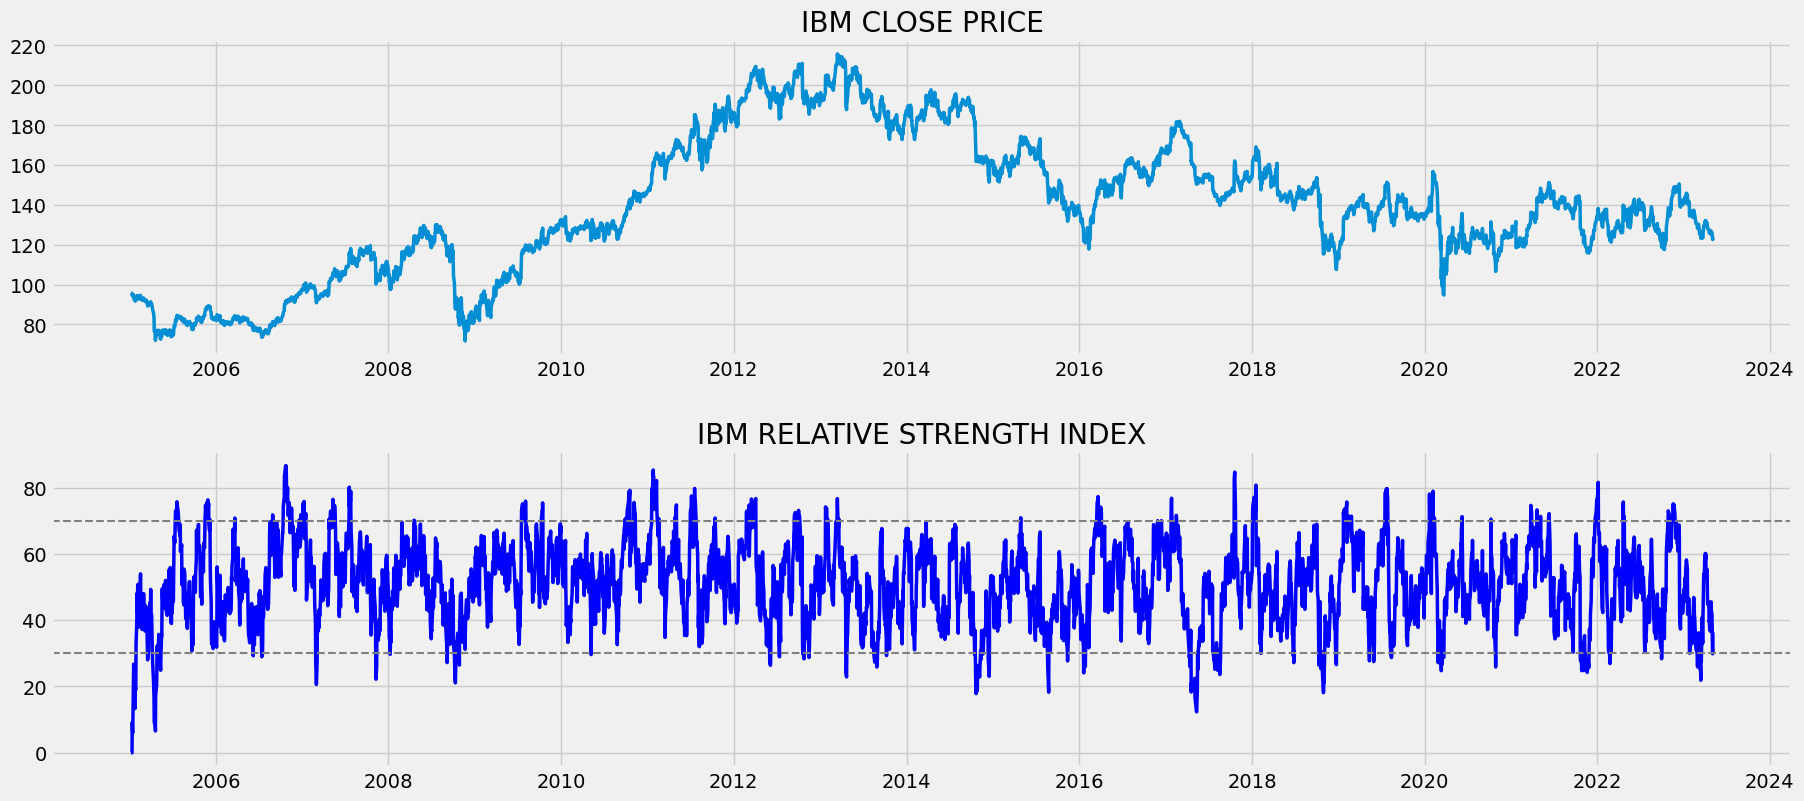

In [12]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5)
ax1.set_title('IBM CLOSE PRICE')
ax2.plot(ibm['rsi_14'], color = 'blue', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.set_title('IBM RELATIVE STRENGTH INDEX')
plt.show()

In [13]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

buy_price, sell_price, rsi_signal = implement_rsi_strategy(ibm['close'], ibm['rsi_14'])

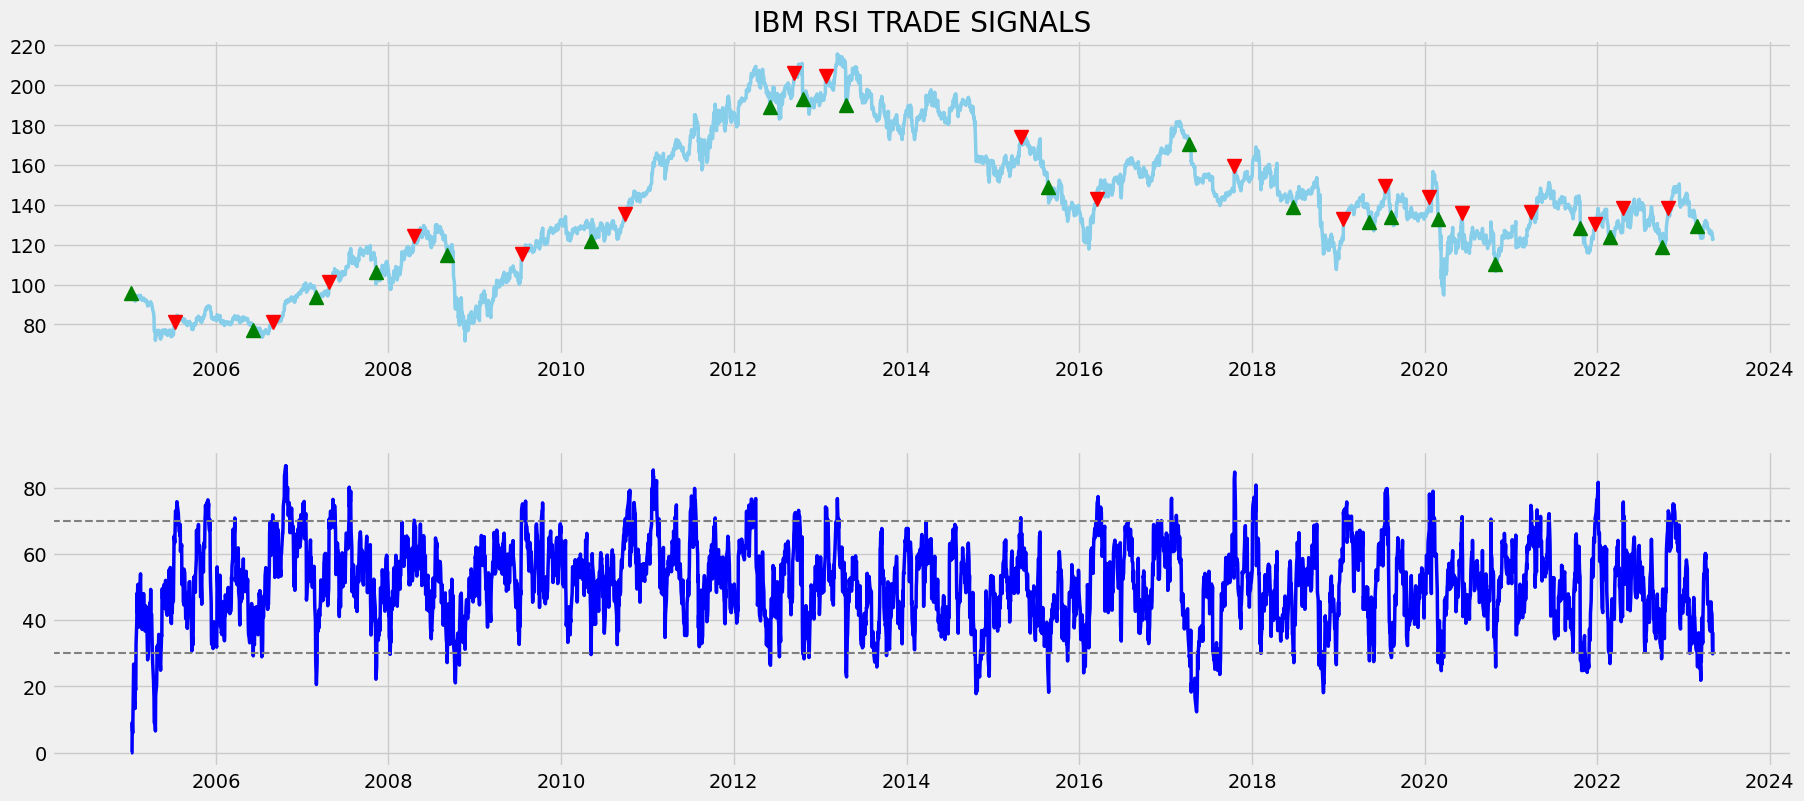

In [14]:
ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax1.plot(ibm['close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
ax1.plot(ibm.index, buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax1.plot(ibm.index, sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('IBM RSI TRADE SIGNALS')
ax2.plot(ibm['rsi_14'], color = 'blue', linewidth = 2.5)
ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [15]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(ibm['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = ibm['rsi_14']
close_price = ibm['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(ibm.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(ibm.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
2005-01-07,95.78,0.000000,1,1
2005-01-10,95.68,0.000000,0,1
2005-01-11,95.00,0.000000,0,1
2005-01-12,95.21,9.137812,0,1
2005-01-13,94.45,6.738102,0,1


In [16]:
ibm_ret = pd.DataFrame(np.diff(ibm['close'])).rename(columns = {0:'returns'})
rsi_strategy_ret = []

for i in range(len(ibm_ret)):
    returns = ibm_ret['returns'][i]*strategy['rsi_position'][i]
    rsi_strategy_ret.append(returns)
    
rsi_strategy_ret_df = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/ibm['close'][-1])
rsi_investment_ret = []

for i in range(len(rsi_strategy_ret_df['rsi_returns'])):
    returns = number_of_stocks*rsi_strategy_ret_df['rsi_returns'][i]
    rsi_investment_ret.append(returns)

rsi_investment_ret_df = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing $100k in IBM : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in IBM : 86084.32
Profit percentage of the RSI strategy : 86%
